In [1]:
AOI = 'gabon'
elev_name = 'Elevation_ocean-GEBCO_land-GLO30_above12200m-wdpower_below12200m-plane_wetland-uni0m_lakes-uni1m'

In [2]:
import sys
import os
import pandas as pd
import shutil
from datetime import datetime
from string import Template
import fnmatch
import geopandas as gpd
import rasterio
from osgeo import gdal 
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [3]:
path = '/Users/Alchrist/Documents/Github/ANUGA/' #(os.path.dirname(os.getcwd())) + '/'
path_code = path + '/processing/code/'
path_templates = path + '/processing/templates/'
path_configss = path + '/processing/configs/'
path_examples =  '/Volumes/FortressL3/ANUGA/SWOT_Sim/examples/' 

sys.path.insert(1,path_code)
from BYOM_Utilities_V1 import (build_directory, 
                               setup_AOI_files, 
                               make_polygons,
                               make_channel_networks,
                               make_model_foundation, 
                               set_boundary_conditions, 
                               make_watermask, get_tidal_boundary, get_inlet, get_tide_data_pytmd)


/users/alchrist/documents/github/ANUGA/processing/code/raster_bridges.py:39: UserWarning: ShapelyDeprecationWarning
  warnings.warn('ShapelyDeprecationWarning')
/users/alchrist/documents/github/ANUGA/processing/code/raster_bridges.py:40: UserWarning: UserWarning
  warnings.warn('UserWarning')


In [4]:
skip = False
res = 30 #meters
print('\n')
print('Study area is ' + AOI)
print('Resolution of this setup is %sm' %(res))

working_path,folders = build_directory(path_examples, AOI)




Study area is gabon
Resolution of this setup is 30m



##############################################################################################
################################[Step 1][Build Directory]#####################################
##############################################################################################

##################### The working directory set as: 

/Volumes/FortressL3/ANUGA/SWOT_Sim/examples/gabon/
 
##################### Folders are:
##################### 0 User_Defined_Files --> User shapefile of model domain and water mask
##################### 1 tmp --> For temporary files
##################### 3 Meshes --> Where we will build model meshes
##################### 4 DEMs --> Where we will build digital elevation models
##################### 5 Boundaries --> Where we will store boundary files
##################### 6 Simulations --> Where we will run simulations
##################### 7 Setup_Files/Setup_SHP --> Shapefiles for setup 
########

In [5]:
parameters = pd.read_csv('%s/%s_Configuration.csv' %(folders[2],AOI))
EPSG = int(parameters['EPSG'])

<font size='5' color = 'red' > STEP #8: <br> Get the boundary conditions for the model </font>


In [6]:
try:
    tide_bnd = gpd.read_file('%s%s_tidebnd.shp' %(folders[0],AOI))
    
except:
    print('Tidal boundary is not defined yet')
    tide_bnd_EPSG = []
    tideLAT_EPSG = -9999
    tideLON_EPSG = -9999

else:
    print('Tidal boundary is defined by User File (%s_tidebnd.shp)' %(AOI))
    if tide_bnd.crs != 'EPSG:4326':
        tide_bnd = tide_bnd.to_crs('EPSG:4326')    
    tide_centroid = tide_bnd.centroid

    tide_bnd_EPSG = tide_bnd.to_crs('EPSG:%s' %(EPSG))
    tide_EPSG_centroid = tide_bnd_EPSG.centroid

    tideLAT_EPSG = round(tide_EPSG_centroid.geometry[0].coords.xy[1][0],2)
    tideLON_EPSG = round(tide_EPSG_centroid.geometry[0].coords.xy[0][0],2)



Tidal boundary is not defined yet


In [7]:
boundary_segments,tideLON_EPSG,tideLAT_EPSG = get_tidal_boundary(AOI,folders,res,parameters,tide_bnd_EPSG,tideLAT_EPSG,tideLON_EPSG,elev_name)





##############################################################################################
##############################[Step 8A][Get Tidal Boundary]###############################
##############################################################################################


[Step 8A][Get Tidal Boundary][Find Tidal Boundary] .......


[Step 8A][Set_Boundary_Conditions][Deepest model side = downstream boundary, tidal conditions] .......


[Step 8A][Get Tidal Boundary] Finished .......



In [8]:

tides = gpd.GeoDataFrame(geometry = gpd.points_from_xy(x=[tideLON_EPSG],y=[tideLAT_EPSG]),crs='EPSG:%s' %(EPSG))

print('Tide centroid is LAT: %s LON: %s ' %(tideLAT_EPSG,tideLON_EPSG))

tideLON_4326 = round(tides.to_crs('EPSG:4326').geometry[0].coords.xy[0][0],4)
tideLAT_4326 = round(tides.to_crs('EPSG:4326').geometry[0].coords.xy[1][0],4)

print('Tide centroid is LAT: %s LON: %s ' %(tideLAT_4326,tideLON_4326))


Tide centroid is LAT: 34670.08 LON: 503735.46 
Tide centroid is LAT: 0.3137 LON: 9.0337 


In [9]:

tide_path = folders[5] + '/Tide_LAT%s_LON%s/' %(tideLAT_4326,tideLON_4326)

Path(tide_path).mkdir(parents=True, exist_ok=True)

boundary_segments.to_file('%s%s_Boundary_Segments.shp' %(tide_path,AOI))

In [10]:
tide_data = get_tide_data_pytmd(AOI,tide_path,tideLON_4326,tideLAT_4326)
                                
            


[Step 9][Set_Boundary_Conditions][Set model run period] .......

##################### Default simulation start and end are 20100101 - 20211001

[Step 9][Set_Boundary_Conditions][Get water stage time series from TPXO Global Tide Model] .......

##################### Using tide data from file: gabon_tides_lat0.31_lon9.03_20100101.csv

[Step 9][Set_Boundary_Conditions] Finished .......



In [11]:
try:
    inlet_bnd = gpd.read_file('%s%s_inletbnd.shp' %(folders[0],AOI))
except:
    print('No inlet polygon defined')
    inletLAT_EPSG = -9999
    inletLON_EPSG = -9999
else:
    print('Inlet polygon defined with %s_inletbnd.shp' %(AOI))
    if inlet_bnd.crs != 'EPSG:4326':
        inlet_bnd = inlet_bnd.to_crs('EPSG:4326')    
    inlet_centroid = inlet_bnd.centroid

    inlet_bnd_EPSG = inlet_bnd.to_crs('EPSG:%s' %(EPSG))
    inlet_EPSG_centroid = inlet_bnd_EPSG.centroid

    inletLAT_EPSG = round(inlet_EPSG_centroid.geometry[0].coords.xy[1][0],0)
    inletLON_EPSG = round(inlet_EPSG_centroid.geometry[0].coords.xy[0][0],0)


No inlet polygon defined


In [12]:
intersections, inletLON_EPSG,inletLAT_EPSG = get_inlet(AOI,folders,res,parameters,inletLON_EPSG,inletLAT_EPSG,elev_name)




##############################################################################################
##############################[Step 8b][Get Inlet Location]###############################
##############################################################################################


[Step 8b][Get Inlet Location][Find River Boundary] .......


[Step 8b][Get Inlet Location][Largest river channel along model edge = upstream boundary, river discharge conditions] .......

##################### Discharge boundary conditions set at 611876,19952

[Step 8b][Get Inlet Location] Finished .......



In [13]:
inlet_bnd = gpd.GeoDataFrame(geometry = gpd.points_from_xy(x=[inletLON_EPSG],y=[inletLAT_EPSG]),crs='EPSG:%s' %(EPSG))

print('Inlet centroid is LAT: %s LON: %s ' %(inletLAT_EPSG,inletLON_EPSG))

inletLAT_4326 = round(inlet_bnd.to_crs('EPSG:4326').geometry[0].coords.xy[1][0],4)
inletLON_4326 = round(inlet_bnd.to_crs('EPSG:4326').geometry[0].coords.xy[0][0],4)

print('Inlet centroid is LAT: %s LON: %s ' %(inletLAT_4326,inletLON_4326))


Inlet centroid is LAT: 19952 LON: 611876 
Inlet centroid is LAT: 0.1805 LON: 10.0055 


In [14]:
inlet_path = folders[5] + '/Inlet_LAT%s_LON%s/' %(inletLAT_4326,inletLON_4326)

Path(inlet_path).mkdir(parents=True, exist_ok=True)

inlet_bnd.to_file('%sinlet_bnd_LAT%s_LON%s.shp' %(inlet_path,inletLAT_4326,inletLON_4326))



In [15]:

# boundaries,upstreamX,upstreamY,tideX,tideY = set_boundary_conditions(AOI,folders,res,parameters)


In [16]:
from rasterio.plot import show
from rasterio.mask import mask
model_domain = gpd.read_file('%s%s_modeldomain.shp' %(folders[7],AOI))
AOI_extent = gpd.read_file('%s%s_extent_%s.shp' %(folders[7],AOI,EPSG))

watermask = rasterio.open('%s%s_watermask_%s.tif' %(folders[8],AOI,res))
masked, mask_transform = mask(dataset=watermask,shapes=model_domain.geometry,crop=False)
masked = np.where(masked==-9999,np.nan,masked)

origin_x = watermask.profile['transform'][2]
origin_y = watermask.profile['transform'][5]

tides = gpd.GeoDataFrame(geometry = gpd.points_from_xy([tideLON_EPSG],[tideLAT_EPSG]),crs='EPSG:%s' %(EPSG))


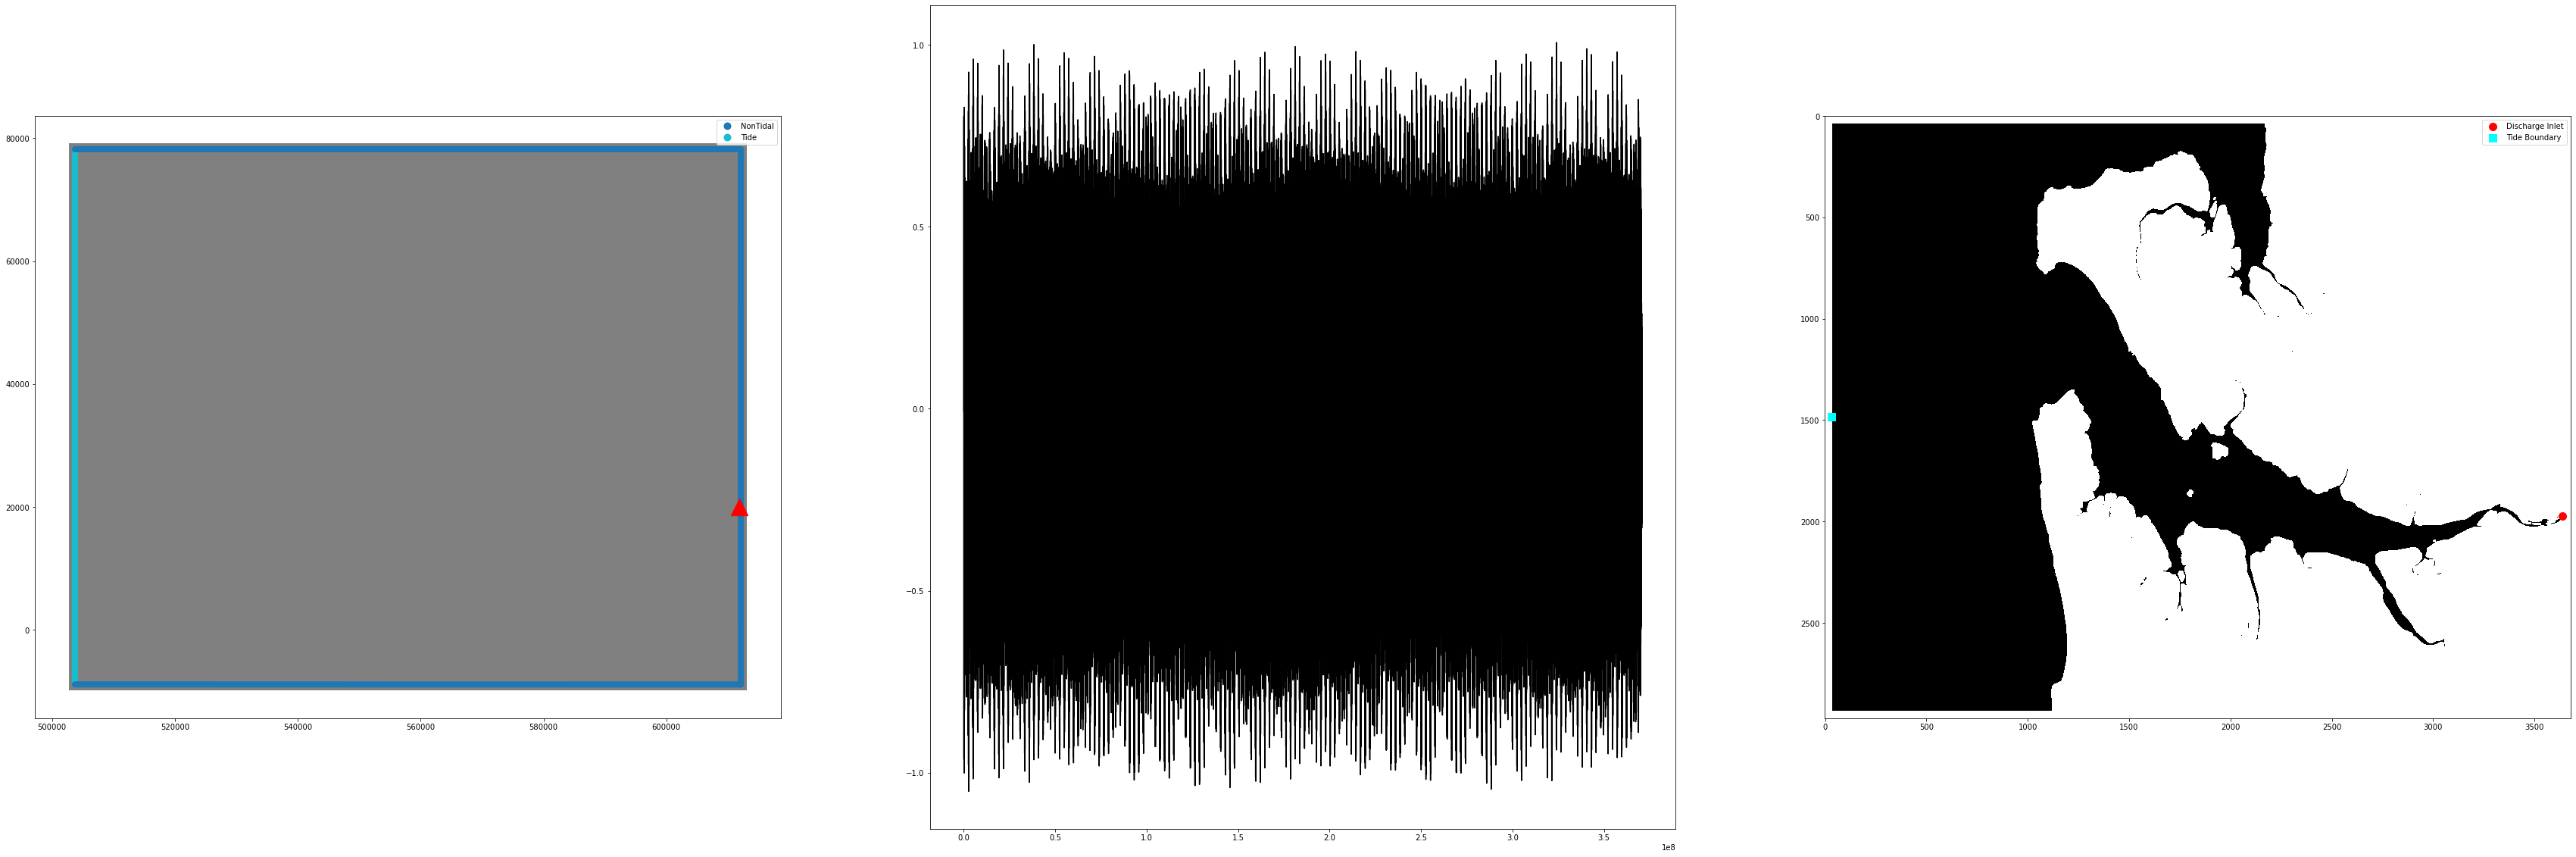

In [17]:

fig,[ax1,ax2,ax3] = plt.subplots(ncols=3,figsize=(60,20))

AOI_extent.plot(ax=ax1,color='grey',legend = True,label='model domain')
boundary_segments.plot(ax=ax1,categorical=True,legend=True,column='boundary')
ax1.scatter(inletLON_EPSG,inletLAT_EPSG,color='red',marker='^',s=500,label='Inlet')

ax2.plot(tide_data[:,0],tide_data[:,1],'black')

ax3.imshow(masked[0],'gray')
ax3.scatter((inletLON_EPSG-origin_x)/res,(origin_y - inletLAT_EPSG)/res, s=100, c='red', marker='o',label='Discharge Inlet')
ax3.scatter((tides.geometry[0].coords[0][0]-origin_x)/res,(origin_y - tides.geometry[0].coords[0][1])/res, s=100, c='cyan', marker='s',label='Tide Boundary')
ax3.legend()

plt.legend()
plt.savefig('%s/%s_model_boundaries_TideLAT%s_TideLON%s_InletLAT%s_InletLON%s.png' %(folders[5],AOI,tideLAT_4326,tideLON_4326,inletLAT_4326,inletLON_4326),dpi=400,bbox_inches='tight')